## Curve fiting outputs of proteins and MD of proteins 

***Section 2***

In [3]:
library(ggplot2)
library(dplyr)
library(knitr)
library(ggforce)
library(arrow)


Attachement du package : 'arrow'


L'objet suivant est masqu'e depuis 'package:utils':

    timestamp




In [2]:
df <- read.csv("../00.exploratory_analysis/inputs/proteomics_data/norm_signal_filtered.csv", sep= ',')

df <- df[df$Metadata_Categories != "JUMP Control", ]
df <- df[df$Metadata_Compound != "UNTREATED", ]


***Figure 3A***

In [4]:
compound_count_per_protein= read.csv("../01.dose_response/outputs/compound_count_per_protein.csv", sep = ",")

print(head(compound_count_per_protein))

  gene.id n_compounds
1  Q14393          16
2  P09341          14
3  Q9H2A7          14
4  P0DJI8          13
5  Q12805          13
6  Q15113          13
                                                                                                                                                                                                                                                                     compound_list
1 Actinomycin D, Ethoxyquin, Amperozide, IOPANOIC ACID, Lys05, 5,8,11-Eicosatriynoic acid, Cycloheximide, CLIOQUINOL, Berberine chloride, Cucurbitacin I, Triamcinolone acetonide, Staurosporine, FCCP, Calcipotriol (hydrate), Colistin Methanesulfonate (sodium salt), Fluazinam
2        Actinomycin D, Ethoxyquin, Amperozide, 5,8,11-Eicosatriynoic acid, Cycloheximide, Berberine chloride, Cucurbitacin I, Triamcinolone acetonide, Staurosporine, FCCP, Calcipotriol (hydrate), Aminodarone Hydrochloride, Colistin Methanesulfonate (sodium salt), Fluazinam
3                    

In [6]:
final_df= read.csv("../01.dose_response/outputs/results_POD_prot.csv", sep = ",")

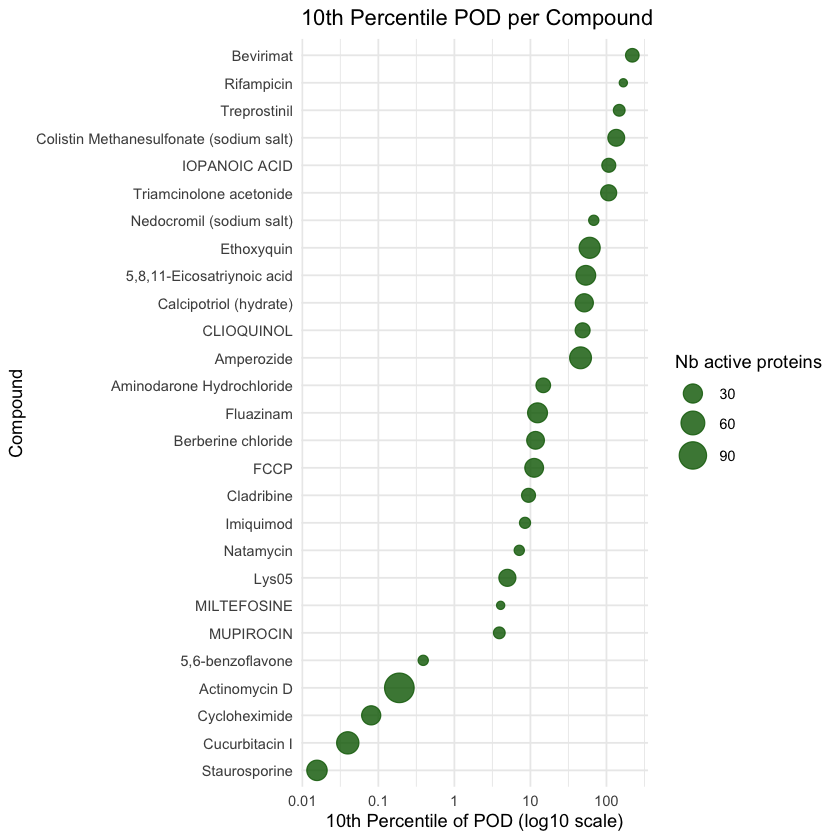

In [7]:
### Calculate the 10th percentile of BMD for each compound across all protein bmds 

compound_categories <- df %>%
  select(Metadata_Compound, Metadata_Categories) %>%
  distinct() %>%
  rename(compound = Metadata_Compound, category = Metadata_Categories)

pod_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  ) %>%
  left_join(compound_categories, by = "compound") %>%
  arrange(desc(nb_proteins))


#print(pod_summary, n=Inf)

ggplot(pod_summary, aes(x = pod_10th_percentile, y = reorder(compound, pod_10th_percentile))) +
  geom_point(aes(size = nb_proteins), color = "darkgreen", alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_size_continuous(range = c(2, 8)) +  # ajuste la taille des points ici
  labs(title = "10th Percentile POD per Compound",
       x = "10th Percentile of POD (log10 scale)",
       y = "Compound",
       size = "Nb active proteins") +
  theme_minimal()



-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v stringr   1.5.1
v lubridate 1.9.4     v tibble    3.2.1
v purrr     1.0.4     v tidyr     1.3.1
v readr     2.1.5     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attachement du package : 'cowplot'


L'objet suivant est masqu'e depuis 'package:lubridate':

    stamp


Warning message:
"Vectorized input to `element_text()` is not officially supported.
i Results may be unexpected or may change in future versions of ggplot2."


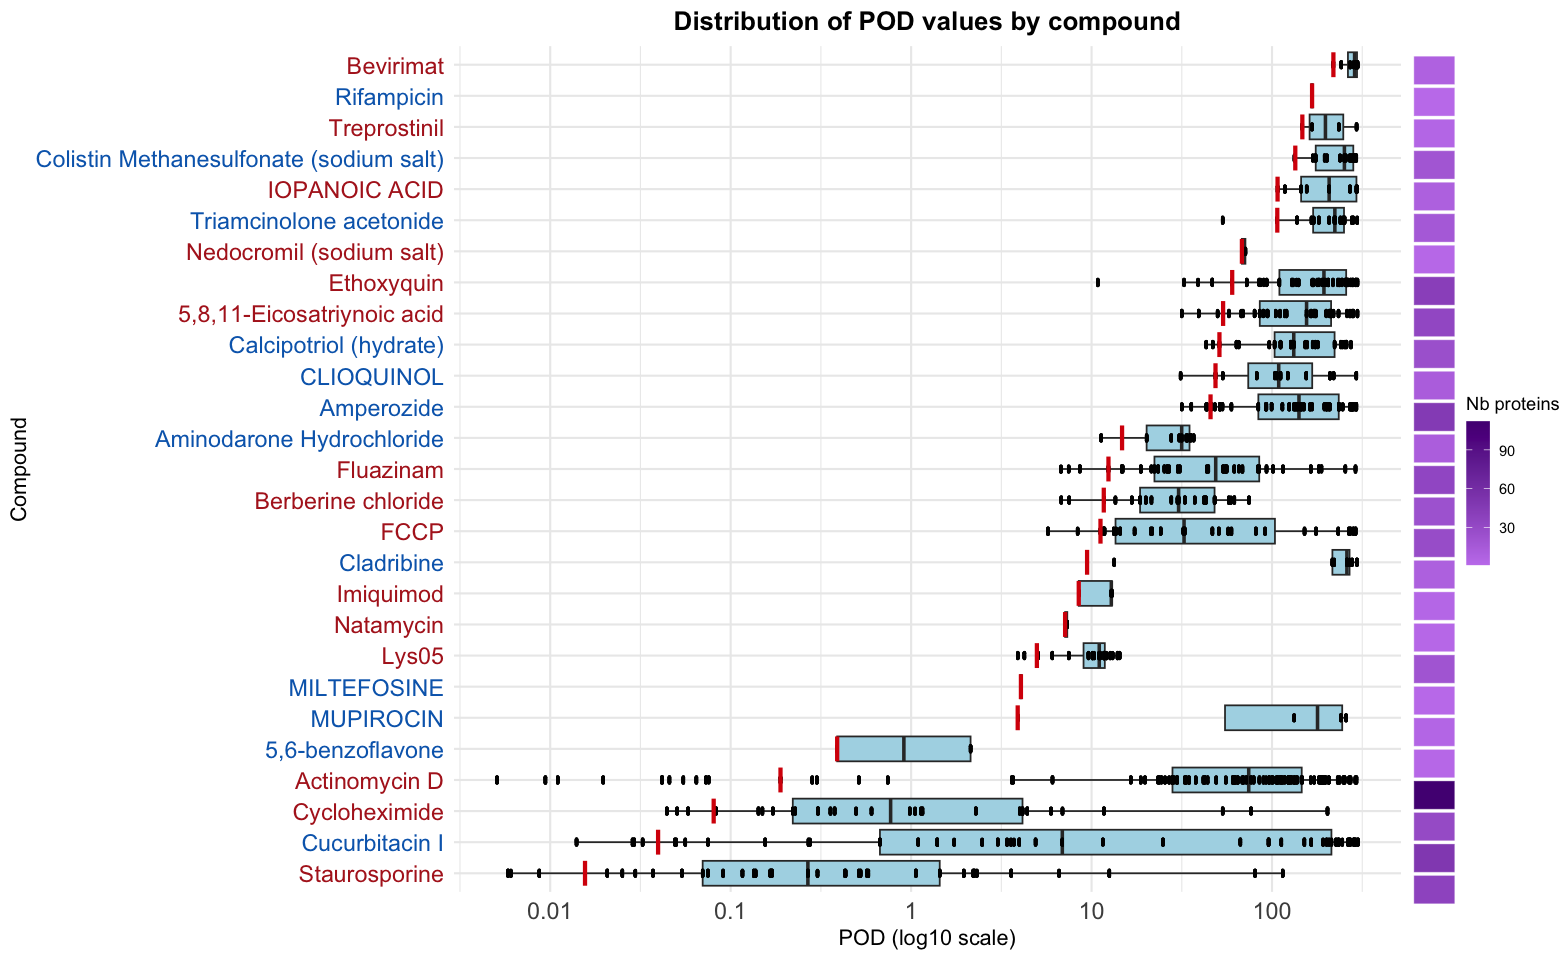

In [8]:
library(tidyverse)
library(cowplot)

df_bmd <- final_df %>%
  filter(!is.na(Concentration), Concentration > 0)

compound_categories <- df %>%
  select(Metadata_Compound, Metadata_Categories) %>%
  distinct() %>%
  filter(!Metadata_Compound %in% c("Troglitazone", "PEMIROLAST POTASSIUM", "DMSO")) %>%
  rename(compound = Metadata_Compound, category = Metadata_Categories) %>%
  mutate(category = case_when(
    grepl("Positive", category, ignore.case = TRUE) ~ "positive",
    grepl("Negative", category, ignore.case = TRUE) ~ "negative",
    TRUE ~ "other"
  ))

compound_order <- final_df %>%
  filter(!is.na(Concentration), Concentration > 0) %>%
  group_by(compound) %>%
  summarise(pod_10th = quantile(Concentration, probs = 0.10, na.rm = TRUE)) %>%
  right_join(compound_categories, by = "compound") %>%
  mutate(pod_10th = ifelse(is.na(pod_10th), Inf, pod_10th)) %>%
  arrange(pod_10th) %>%
  pull(compound)


pod_summary_raw <- final_df %>%
  filter(!is.na(Concentration), Concentration > 0) %>%
  group_by(compound) %>%
  summarise(
    pod_10th = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  )


pod_summary <- compound_categories %>%
  left_join(pod_summary_raw, by = "compound") %>%
  mutate(
    category = replace_na(category, "other"),
    compound = factor(compound, levels = compound_order),
    nb_proteins = replace_na(nb_proteins, 0),
    color_category = case_when(
      category == "positive" ~ "firebrick",
      category == "negative" ~ "#0468ba",
      TRUE ~ "grey30"
    )
  )

df_bmd <- df_bmd %>%
  mutate(compound = factor(compound, levels = compound_order))


p_main <- ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  geom_segment(data = pod_summary %>% filter(!is.na(pod_10th)), 
               aes(x = log10(pod_10th), xend = log10(pod_10th),
                   y = as.numeric(compound) - 0.4, 
                   yend = as.numeric(compound) + 0.4),
               color = "#d70307", linewidth = 1.2) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  labs(
    title = "Distribution of POD values by compound",
    x = "POD (log10 scale)",
    y = "Compound"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(
      size = 14,
      color = pod_summary$color_category
    ),
    plot.title = element_text(hjust = 0.5, face = "bold")
  )

p_proteins <- ggplot(pod_summary, aes(y = compound, x = 1, fill = nb_proteins)) +
  geom_tile(color = "white", height = 0.9) +
  scale_fill_gradient(name = "Nb proteins", low = "#c583ed", high = "#540883") +
  theme_void() +
  theme(legend.position = "right") +
  theme(legend.key.width = unit(0.5, "cm")) +
  coord_fixed(ratio = 0.77)

final_plot <- plot_grid(
  p_main,
  p_proteins,
  ncol = 2,
  rel_widths = c(0.905, 0.095)  # Moins de place pour la heatmap
)


options(repr.plot.width = 13, repr.plot.height = 8)
print(final_plot)


In [ ]:
#write.csv(pod_summary, "/Users/grigoryanmariam/Downloads/proteomic_bmd_dose_results.csv", row.names = FALSE)


There are two protein ids: P01137.1 and P40933.1 that we don't have the name in gene_ids.csv. For those I put the name of proteins P01137 and P40933. 

In [13]:
## load the parameters of the bmd curves with protein names, concentration and bmd values

all_bmd_pass_new <- read.csv("../01.dose_response/outputs/bmd_pass_with_protein_name.csv", sep = ",")

***Figure S7***

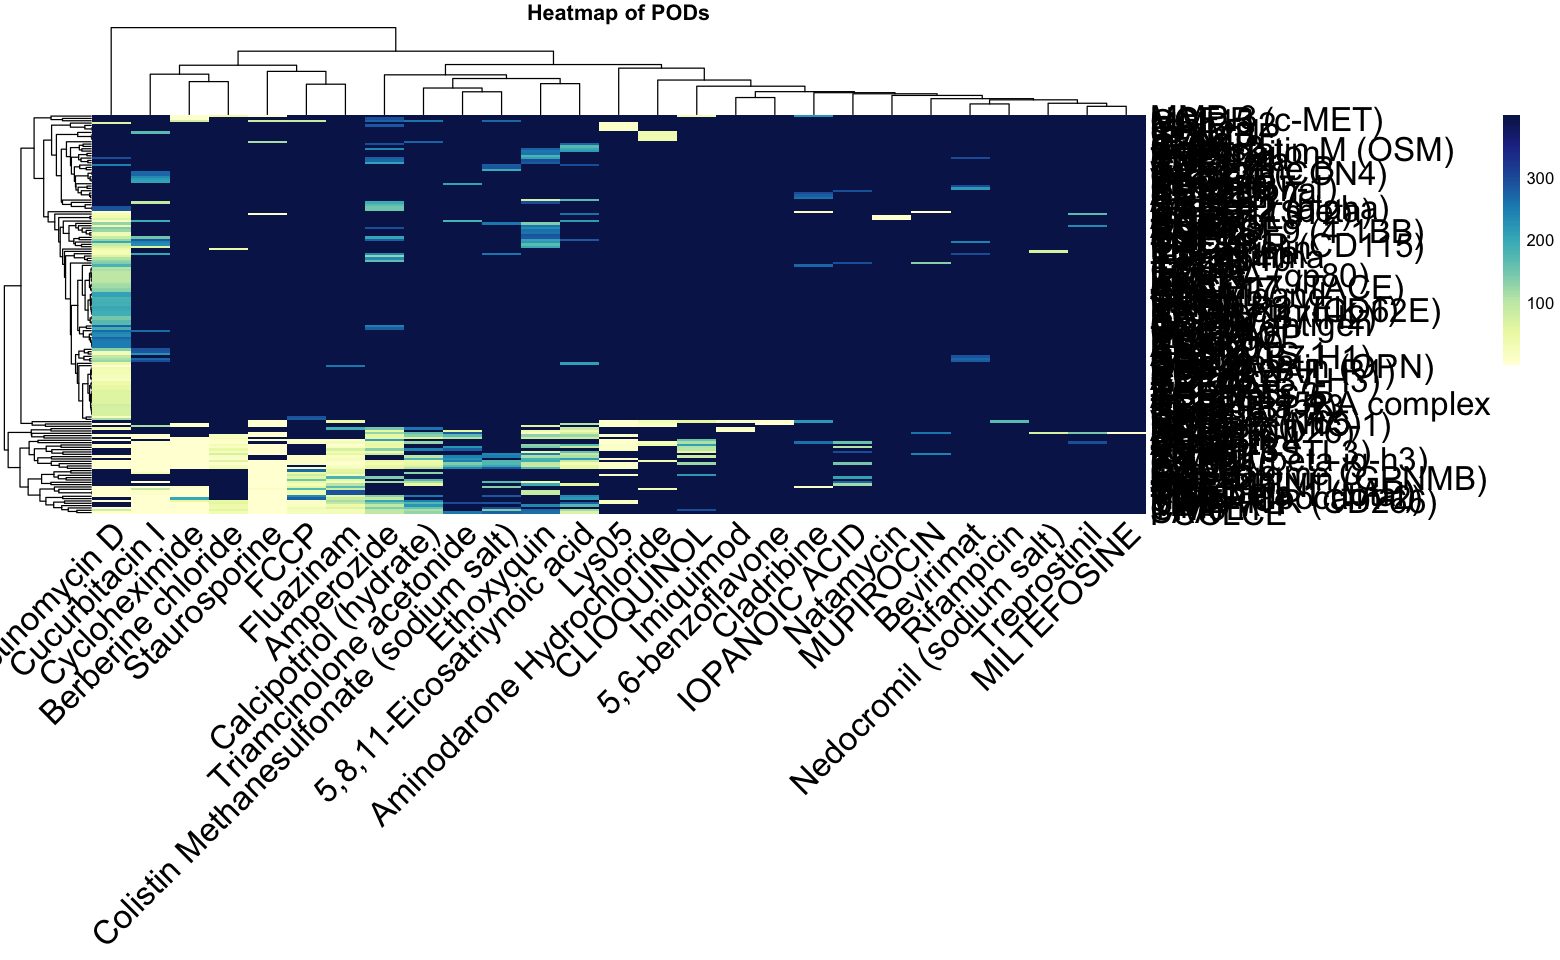

In [ ]:
## clustered heatmap of POD values using pheatmap


library(pheatmap)

compound_name <- unique(all_bmd_pass_new$compound_name)
active_prots <- all_bmd_pass_new %>%
  select(Protein = protein, Compound = compound_name, Concentration)


active_prots <- active_prots %>%
  filter(Compound %in% compound_name)
heatmap_data <- active_prots %>%
  pivot_wider(names_from = Compound, values_from = Concentration) %>%
  column_to_rownames("Protein")


max_value <- max(heatmap_data, na.rm = TRUE)


heatmap_data[is.na(heatmap_data)] <- max_value + 100

heatmap_matrix <- as.matrix(heatmap_data)

pheatmap(
  heatmap_matrix,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  display_numbers = FALSE,
  color = colorRampPalette(RColorBrewer::brewer.pal(9, "YlGnBu"))(100),
  main = "Heatmap of PODs",
  fontsize_row = 10,
  fontsize_col = 10,
  angle_col = 45,
  na_col = "grey90"
)

In [ ]:
# saving the heatmap as a png file
heatmap_plot <- pheatmap(heatmap_matrix,
                         cluster_rows = TRUE,
                         cluster_cols = TRUE,
                         display_numbers = FALSE,
                         color = colorRampPalette(RColorBrewer::brewer.pal(9, "YlGnBu"))(100),
                         main = "Heatmap of POD values",
                         fontsize_row = 11,
                         fontsize_col = 14,
                         angle_col = 45,
                         na_col = "grey90",
                         silent = TRUE) 

png("../01.dose_response/figures/heatmap_proteins.png", width = 15 * 1200, height = 26 * 1200, res = 1200)
grid::grid.newpage()
grid::grid.draw(heatmap_plot$gtable)
dev.off()


pdf 
  2

## MH distance Proteins

In [4]:
## loading parquet file of already ready mahalanobis distances between the compounds and DMSO centroids 


md_data_prot= read_parquet("../01.dose_response/outputs/prot_distances.parquet")

md_data_prot = as.data.frame(md_data_prot)

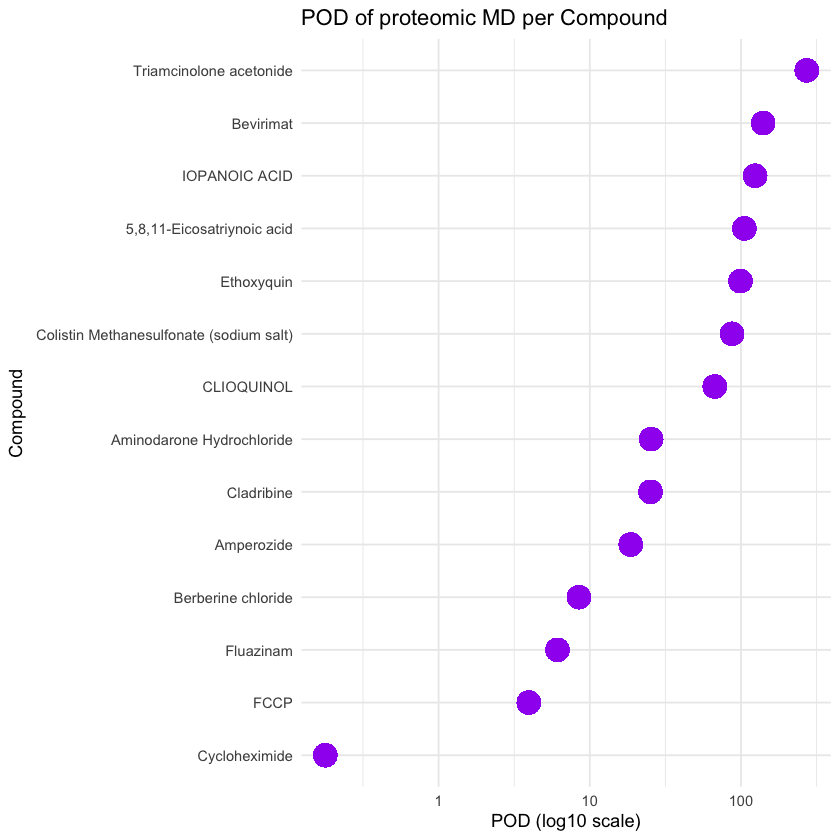

In [5]:
### scatter of POD values 

final_df_md_prot = read.csv("../01.dose_response/outputs/results_MD_prot.csv", sep = ",")

ggplot(final_df_md_prot, aes(x = Concentration, y = reorder(compound, Concentration ))) +
  geom_point(color = "purple", alpha = 3,  size = 6) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_size_continuous(range = c(2, 8)) + 
  labs(title = "POD of proteomic MD per Compound",
       x = "POD (log10 scale)",
       y = "Compound") +
  theme_minimal()

## Comparing the 10th Percentile of protein PODs and MD POD

***Section 3 / Figure 4***

In [19]:
library(patchwork)

## loading the results of different PODs

final_df_md <- read.csv("../01.dose_response/outputs/results_MD_CP_data.csv", header = TRUE)


final_df_md_prot <- read.csv("../01.dose_response/outputs/results_MD_prot.csv", header = TRUE)

final_df_prot <- read.csv("../01.dose_response/outputs/results_POD_prot.csv", header = TRUE)

final_df_cp_2 <- read.csv("../01.dose_response/outputs/results_POD_CP_data_10_perc.csv", header = TRUE)

final_df_cp <- read.csv("../01.dose_response/outputs/results_bmd_CP_data.csv", header = TRUE)

In [20]:
pod_summary_proteins <- final_df_prot %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein),
    .groups = "drop"
  ) %>%
  mutate(type = "Proteomic")

pod_summary_md <- final_df_md_prot %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = unique(Concentration),
    nb_proteins = 1,  
    .groups = "drop"
  ) %>%
  mutate(type = "Proteomic MD")

pod_summary_cp <- final_df_md %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein),
    .groups = "drop"
  ) %>%
  mutate(type = "CP MD")

pod_summary_cp_2 <- final_df_cp %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein),
    .groups = "drop"
  ) %>%
  mutate(type = "CP")

pod_summary_combined <- bind_rows(pod_summary_proteins, pod_summary_md, pod_summary_cp, pod_summary_cp_2)

compound_order <- pod_summary_combined %>%
  filter(type == "Proteomic") %>%
  arrange(pod_10th_percentile) %>%
  pull(compound)%>%
  union("PEMIROLAST POTASSIUM")

p <- ggplot(pod_summary_combined, aes(x = pod_10th_percentile, y = factor(compound, levels = compound_order))) +
  geom_point(aes(color = type, size = nb_proteins), alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100, 1000),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100", "1000")
  ) +
  scale_color_manual(values = c(
    "Proteomic" = "#2b6c2b",
    "Proteomic MD" = "#c75200",
    "CP MD" = "#0073c7",
    "CP" = "#cba2e4"
  )) +
  scale_size_continuous(range = c(2, 8)) +
  labs(
    title = "Comparison of POD",
    x = "POD (log10 scale)",
    y = "Compound",
    color = "Type of POD",
    size = "Nb active proteins/features/ MD categories"
  ) +
  theme_minimal(base_size = 14)  # augmente aussi la taille du texte


# Sauvegarder en grand format (par exemple, PNG 16x10 pouces)
ggsave("../01.dose_response/figures/POD_comparison_plot.png", plot = p, width = 12, height = 10, dpi = 300)

In [13]:
print(head(pod_summary_combined))


# A tibble: 6 x 4
  compound                   pod_10th_percentile nb_proteins type     
  <chr>                                    <dbl>       <dbl> <chr>    
1 5,6-benzoflavone                         0.389           2 Proteomic
2 5,8,11-Eicosatriynoic acid              53.6            33 Proteomic
3 Actinomycin D                            0.189         112 Proteomic
4 Aminodarone Hydrochloride               14.8            11 Proteomic
5 Amperozide                              45.6            46 Proteomic
6 Berberine chloride                      11.7            23 Proteomic


In [22]:
print(head(final_df_cp_2))

                                 compound pod_10th_percentile_cp nb_features
1 Colistin Methanesulfonate (sodium salt)            118.6733304         154
2              5,8,11-Eicosatriynoic acid             25.3091637         142
3                  Calcipotriol (hydrate)             45.2561433          94
4                              CLIOQUINOL             18.6269172          93
5                           Staurosporine              0.4329405          82
6                               Bevirimat            168.8401063          81


Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_density()`)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 14 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 7 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 5 rows containing missing values"
Warning message:
"Removed 14 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 14 rows containing non-finite outside the scale range
(`stat_density()`)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 16 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 15 rows containing missing values"
Warning message:
"Removed 7 rows containing 

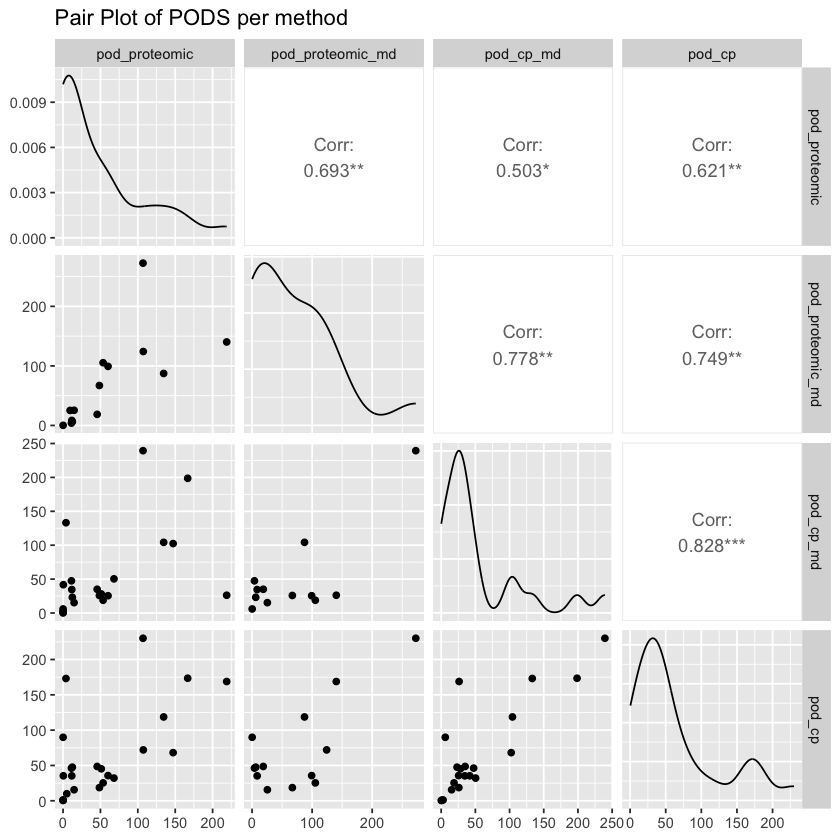

In [23]:
library(GGally)


prot_renamed <- pod_summary_proteins %>%
  select(compound, pod_proteomic = pod_10th_percentile)

md_renamed <- pod_summary_md %>%
  select(compound, pod_proteomic_md = pod_10th_percentile)

cp_renamed <- pod_summary_cp %>%
  select(compound, pod_cp_md = pod_10th_percentile)

cp_renamed_2 <- final_df_cp_2 %>%
  select(compound, pod_cp = pod_10th_percentile_cp)


merged_pods <- prot_renamed %>%
  full_join(md_renamed, by = "compound") %>%
  full_join(cp_renamed, by = "compound")%>%
  full_join(cp_renamed_2, by = "compound")


#print(merged_pods)
ggpairs(
  merged_pods %>% select(-compound),
  title = "Pair Plot of PODS per method"
)

